## Step 1: Import Libraries
### This step loads the libraries required for audio processing, visualization, and web functionality.
### Key libraries include `librosa` for audio feature extraction, `scipy` for signal processing, and `sounddevice` for audio recording.


In [16]:
import os
from flask import Flask, render_template, request
import librosa
import numpy as np
import scipy.io.wavfile as wav
import sounddevice as sd
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt


# Step 2: Define Constants and Paths
### Here, the constants for sample rate, duration, and cutoff frequency are defined.
### Additionally, the necessary directories for storing recordings and uploads are created.


In [17]:
# Paths and folders
REFERENCE_SONG_FOLDER = r"C:\Audio_Recorder_Detector\output_wav_folder"
RECORDINGS_FOLDER = "recordings"
UPLOAD_FOLDER = "uploads"
os.makedirs(RECORDINGS_FOLDER, exist_ok=True)
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

# Recording parameters
SAMPLE_RATE = 44100  # Hz
DURATION = 20  # seconds to record or extract
CUTOFF_FREQ = 3000  # Hz (Low-pass filter cutoff frequency)


# Step 3: Low-pass Filter
### A low-pass filter is implemented to reduce high-frequency noise in the audio signal.
### The Butterworth filter design is used for its smooth frequency response.


In [ ]:
# Low-pass filter implementation
def low_pass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data)
    return filtered_data

# Step 4: Normalize Audio
### This function scales the audio data to have consistent maximum amplitude, ensuring uniformity across recordings.


In [ ]:
def normalize_audio(data):

    max_val = np.max(np.abs(data))
    if max_val > 0:
        return data / max_val
    return data


# Step 5: Record and Save Audio
### This function captures audio from the microphone, applies a low-pass filter, normalizes it, and saves it as a WAV file.


In [ ]:
def record_audio(output_file):
    """
    Records audio from the microphone, applies a low-pass filter, normalizes it, and saves it.
    """
    print(f"Recording for {DURATION} seconds...")
    audio_data = sd.rec(int(DURATION * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1, dtype="float32")
    sd.wait()  # Wait for the recording to finish
    print("Recording complete. Applying low-pass filter...")

    # Apply low-pass filter
    filtered_audio = low_pass_filter(audio_data.flatten(), CUTOFF_FREQ, SAMPLE_RATE)

    # Normalize the audio
    print("Normalizing audio...")
    normalized_audio = normalize_audio(filtered_audio)

    # Convert to int16 for WAV format
    normalized_audio = np.int16(normalized_audio * 32767)

    # Save as a .wav file
    wav.write(output_file, SAMPLE_RATE, normalized_audio)
    print(f"Filtered and normalized audio saved to {output_file}")


# Step 6: Extract Audio Features
### This function extracts Mel-frequency cepstral coefficients (MFCC) and chroma features, which are commonly used in audio analysis.


In [ ]:
def extract_features(audio, sr=44100, n_mfcc=13, is_path=True):

    if is_path:
        audio, _ = librosa.load(audio, sr=sr)  # Load from path
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    return mfcc, chroma


# Step 7: Visualize All Steps
### This step uses matplotlib to visualize the MFCC features extracted from a test WAV file.

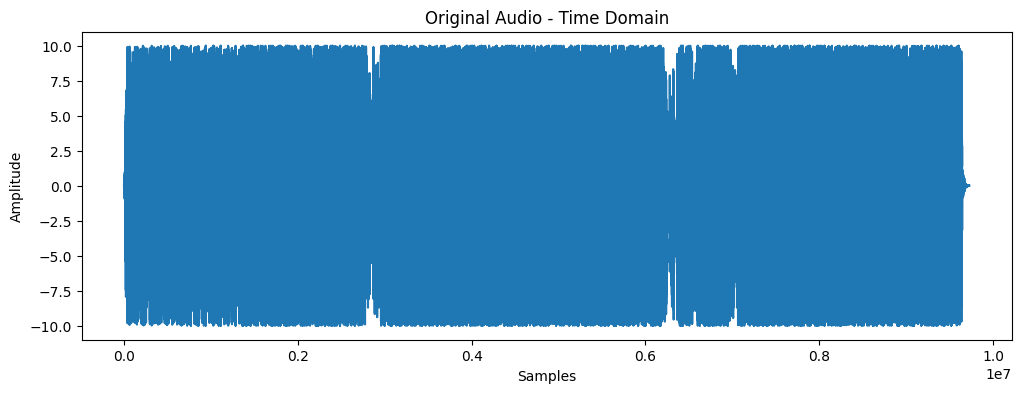

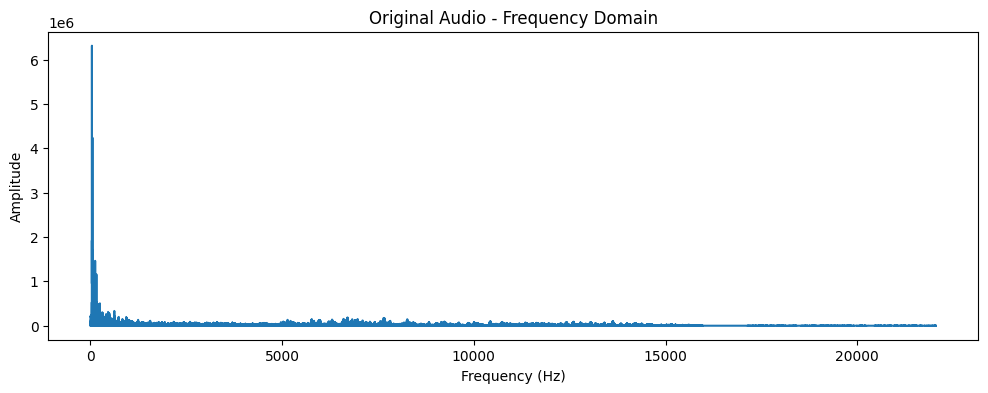

In [22]:
from scipy.fftpack import fft

test_audio_path = r"C:\Audio_Recorder_Detector\uploads\Lil Uzi Vert - 20 Min (1).wav"
audio, sr = librosa.load(test_audio_path, sr=SAMPLE_RATE)

audio*=10 #scaling up for example

# Visualize original audio in time domain
plt.figure(figsize=(12, 4))
plt.plot(audio)
plt.title("Original Audio - Time Domain")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

# Visualize original audio in frequency domain
frequencies = np.abs(fft(audio))[: len(audio) // 2]
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, sr / 2, len(frequencies)), frequencies)
plt.title("Original Audio - Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

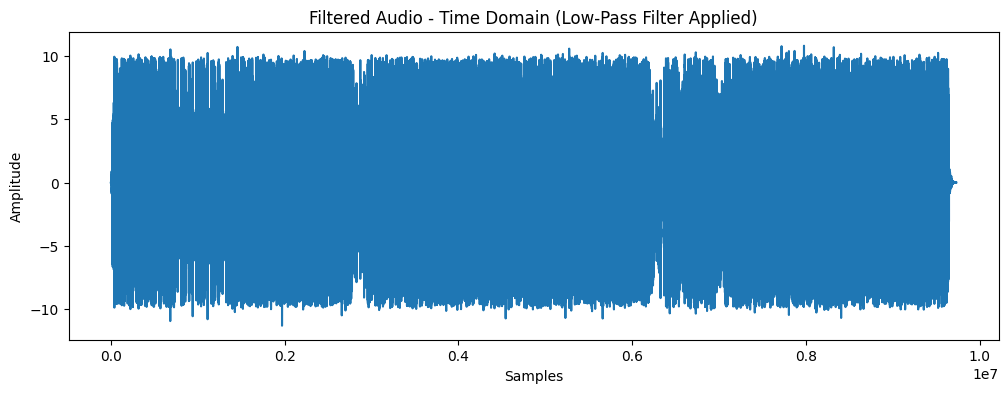

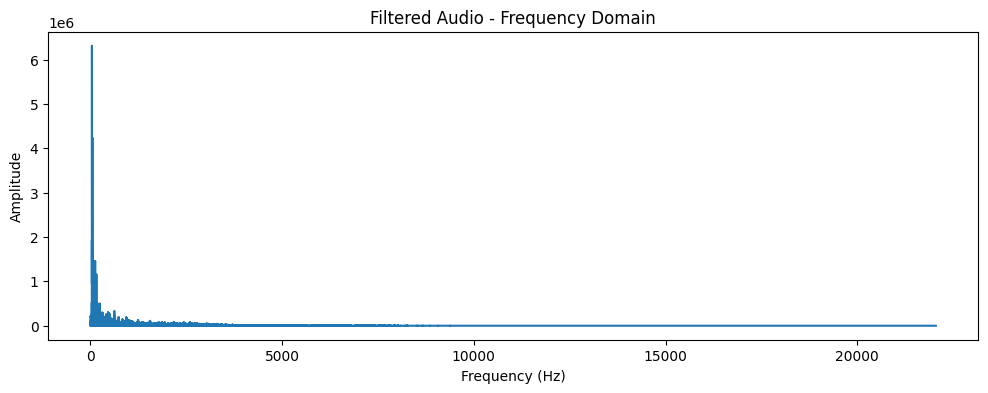

In [23]:
# Apply low-pass filter
filtered_audio = low_pass_filter(audio, CUTOFF_FREQ, sr)

# Visualize filtered audio in time domain
plt.figure(figsize=(12, 4))
plt.plot(filtered_audio)
plt.title("Filtered Audio - Time Domain (Low-Pass Filter Applied)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

# Visualize filtered audio in frequency domain
frequencies = np.abs(fft(filtered_audio))[: len(filtered_audio) // 2]
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, sr / 2, len(frequencies)), frequencies)
plt.title("Filtered Audio - Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()


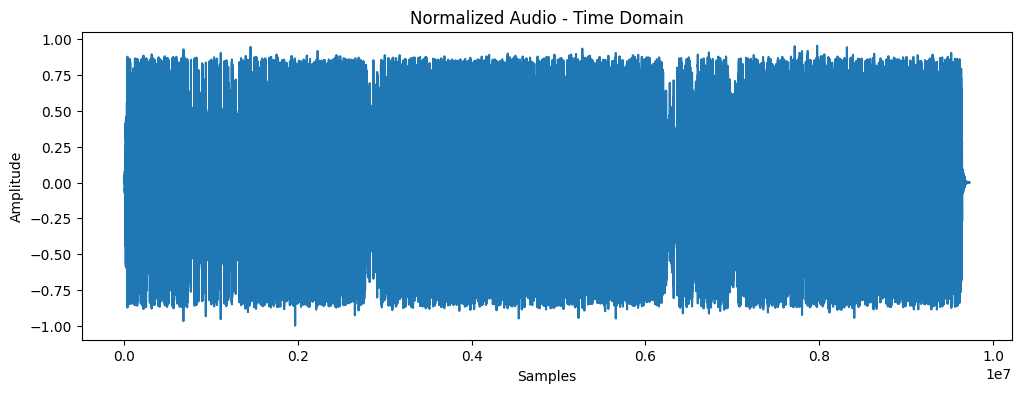

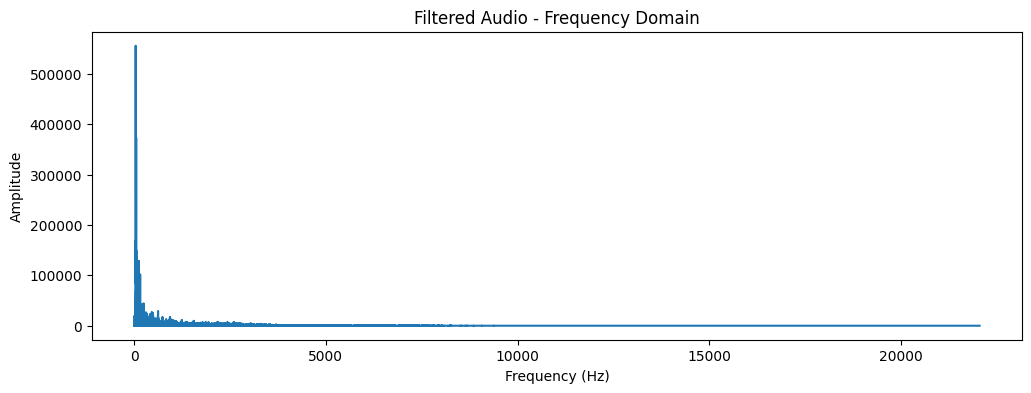

In [24]:
# Normalize the filtered audio
normalized_audio = normalize_audio(filtered_audio)

# Visualize normalized audio in time domain
plt.figure(figsize=(12, 4))
plt.plot(normalized_audio)
plt.title("Normalized Audio - Time Domain")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

frequencies = np.abs(fft(normalized_audio))[: len(normalized_audio) // 2]
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, sr / 2, len(frequencies)), frequencies)
plt.title("Filtered Audio - Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()


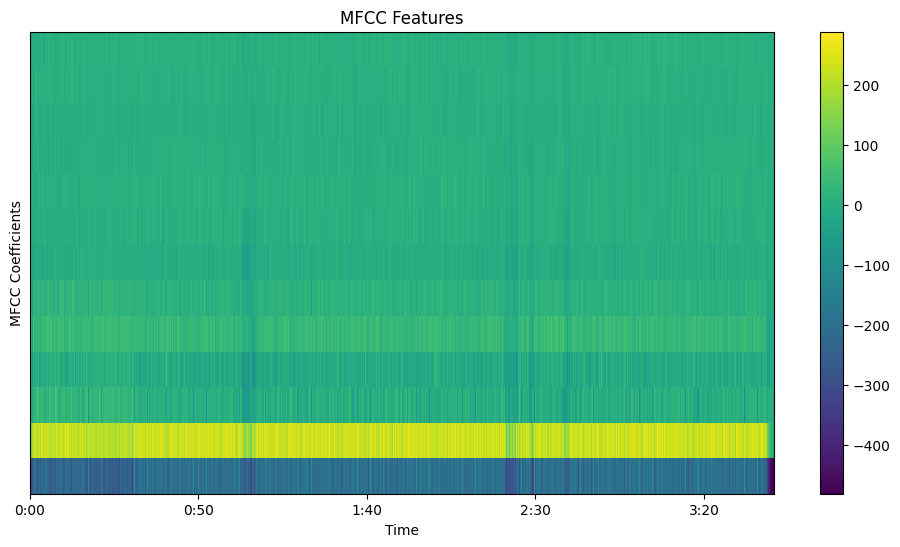

In [25]:
# Extract MFCC features
mfcc_features, _ = extract_features(normalized_audio, sr=sr, is_path=False)

# Visualize MFCC features
plt.figure(figsize=(12, 6))
librosa.display.specshow(mfcc_features, sr=sr, x_axis='time', cmap='viridis')
plt.colorbar()
plt.title("MFCC Features")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.show()


# Step 8: Match Audio to Reference Songs
### This function calculates cross-correlation scores to find the best match between the recorded audio and reference songs.


In [ ]:
def correlate_features(chunk_features, ref_features):
    """
    Compute the cross-correlation between chunk features and reference features.
    """
    chunk_flat = chunk_features.flatten()
    ref_flat = ref_features.flatten()
    return np.correlate(chunk_flat, ref_flat, mode='valid').max()

# Function to match recorded or uploaded audio to the first 10 seconds of full-length songs
def match_full_audio_to_songs(full_audio_path, song_file_mapping, sr=44100, duration=300):
    """
    Match a full-length audio file against the first 'duration' seconds of each reference song.
    """
    # Load the uploaded audio file
    uploaded_audio, _ = librosa.load(full_audio_path, sr=sr)
    uploaded_features, _ = extract_features(uploaded_audio[:duration * sr], sr=sr, is_path=False)

    song_scores = {}
    for song_name, song_path in song_file_mapping.items():
        # Load only the first 'duration' seconds of the reference song
        ref_audio, _ = librosa.load(song_path, sr=sr, duration=duration)
        ref_features, _ = extract_features(ref_audio, sr=sr, is_path=False)
        score = correlate_features(uploaded_features, ref_features)
        song_scores[song_name] = score

    best_match = max(song_scores, key=song_scores.get)
    return best_match, song_scores

In [27]:

# Load reference audio (first 10 seconds)
ref_audio_path = r"C:\Audio_Recorder_Detector\output_wav_folder\Star Wars Episode V - The Empire Strikes Back.wav"
ref_audio, _ = librosa.load(ref_audio_path, sr=sr, duration=DURATION)

# Extract MFCC features of the reference audio
ref_mfcc_features, _ = extract_features(ref_audio, sr=sr, is_path=False)

# Perform correlation
correlation_score = correlate_features(mfcc_features, ref_mfcc_features)
print(f"Correlation score with {os.path.basename(ref_audio_path)}: {correlation_score}")


Correlation score with Star Wars Episode V - The Empire Strikes Back.wav: 172583274.08430946


# Step 9: Flask Web Application
### This section defines the Flask app routes to handle recording, processing, and matching functionalities.


In [31]:
# Flask application
app = Flask(__name__)

@app.route("/")
def index():
    return render_template("index.html")

@app.route("/record", methods=["POST"])
def record():
    output_file = os.path.join(RECORDINGS_FOLDER, "recorded_audio.wav")
    record_audio(output_file)
    return "Recording complete. File saved as 'recorded_audio.wav'. You can now process this file."

@app.route("/process", methods=["POST"])
def process():
    recorded_file = os.path.join(RECORDINGS_FOLDER, "recorded_audio.wav")
    if not os.path.exists(recorded_file):
        return "No recording found. Please record audio first.", 400

    best_match, song_scores = match_full_audio_to_songs(recorded_file, song_file_mapping)
    if best_match:
        match_results = {
            "predicted_song": best_match,
            "match_scores": song_scores
        }
        return render_template("result.html", results=match_results)
    else:
        return render_template("result.html", results={"predicted_song": "No matches found", "match_scores": {}})

@app.route("/match", methods=["POST"])
def match():
    if "file" not in request.files:
        return "No file uploaded", 400
    file = request.files["file"]
    if file.filename == "":
        return "No file selected", 400

    file_path = os.path.join(UPLOAD_FOLDER, file.filename)
    file.save(file_path)

    best_match, song_scores = match_full_audio_to_songs(file_path, song_file_mapping)
    if best_match:
        match_results = {
            "predicted_song": best_match,
            "match_scores": song_scores
        }
        return render_template("result.html", results=match_results)
    else:
        return render_template("result.html", results={"predicted_song": "No matches found", "match_scores": {}})

if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1